In [3]:
# This notebook is demonstrating common techniques that can be used to understand classifier performance
# Load in the MNIST Handwriting dataset
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
# Defint X data and y labels
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [5]:
y.shape

(70000,)

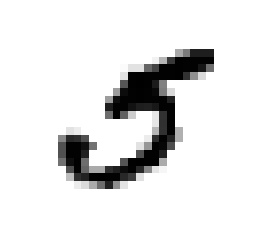

In [6]:
# View what one number looks like - what am I trying to classify?
import matplotlib.pyplot as plt
import matplotlib

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

In [7]:
y[36000]

5.0

In [8]:
# EXTRA
import numpy as np
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

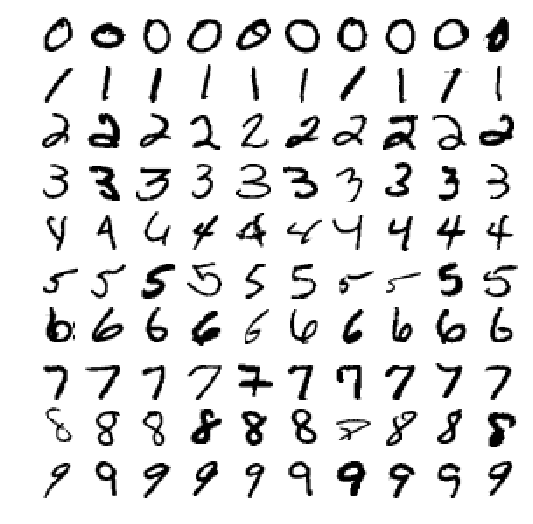

In [9]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [10]:
#Dataset is already divided into test and training sets - yay sklearn!
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [11]:
#Shuffle dataset to avoid too many of the same numbers in one cross-validation fold
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [12]:
#Start by using binary classification to identify a 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

#Test it out using Stochastic Gradient Descent
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [13]:
# Does the classifier accurately predict a 5?
sgd_clf.predict([some_digit])

array([ True], dtype=bool)

In [14]:
# How accurate is the classifier?
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.95965,  0.96175,  0.96255])

In [15]:
#Results are super good - Use a dumb classifier to test if this model is being biased
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.90955,  0.91035,  0.90905])

In [16]:
#Accuracy is not a good metric, lets check out the confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)


array([[53807,   772],
       [ 1549,  3872]])

In [17]:
#Check out precision, recall, and F1
from sklearn.metrics import precision_score, recall_score, f1_score

print("Precision: %.2f" % precision_score(y_train_5, y_train_pred))
print('Recall: %.2f' % recall_score(y_train_5, y_train_pred))
print('F1 Score: %.2f' % f1_score(y_train_5, y_train_pred))

Precision: 0.83
Recall: 0.71
F1 Score: 0.77


In [18]:
#How can we use thresholds to influence classification performance?
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([ 114020.93305371])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True], dtype=bool)

In [20]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False], dtype=bool)

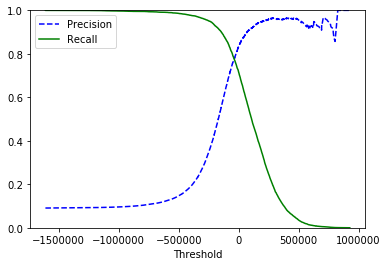

In [21]:
#Find the optimal threshold!
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

In [22]:
#train for 90% precision
y_train_pred_90 = (y_scores > 70000)

print("Precision: %.2f" % precision_score(y_train_5, y_train_pred_90))
print('Recall: %.2f' % recall_score(y_train_5, y_train_pred_90))

Precision: 0.90
Recall: 0.57


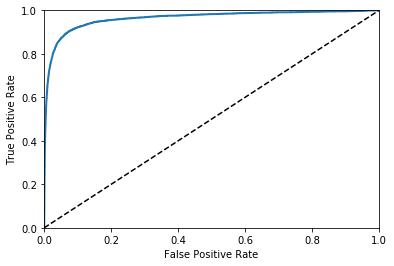

ROC AUC: 0.96


In [23]:
#Visualize performance using a ROC curve
from sklearn.metrics import roc_curve, roc_auc_score

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plot_roc_curve(fpr, tpr)
plt.show()

print('ROC AUC: %.2f' % roc_auc_score(y_train_5, y_scores))

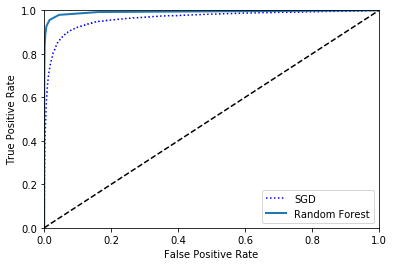

SGD ROC AUC: 0.96
Forest ROC AUC: 0.99


In [24]:
#Lets try random forest to see if we can improve the classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

print('SGD ROC AUC: %.2f' % roc_auc_score(y_train_5, y_scores))
print('Forest ROC AUC: %.2f' % roc_auc_score(y_train_5, y_scores_forest))

In [25]:
#Hurray we improved our binary classifier! Now lets play around with multiclass classifiers
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([ 5.])

In [26]:
len(ovo_clf.estimators_)

45

In [27]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [28]:
forest_clf.predict_proba([some_digit])

array([[ 0.1,  0. ,  0. ,  0. ,  0. ,  0.9,  0. ,  0. ,  0. ,  0. ]])

In [29]:
cross_val_score(ovo_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.91111778,  0.91354568,  0.90843627])

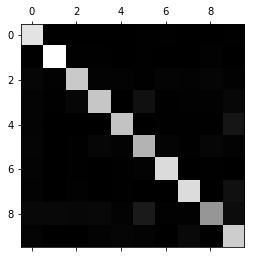

In [30]:
#Error Analysis
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

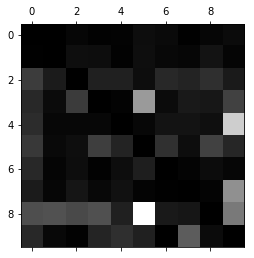

In [31]:
#Fives look darker, lets dig deeper
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

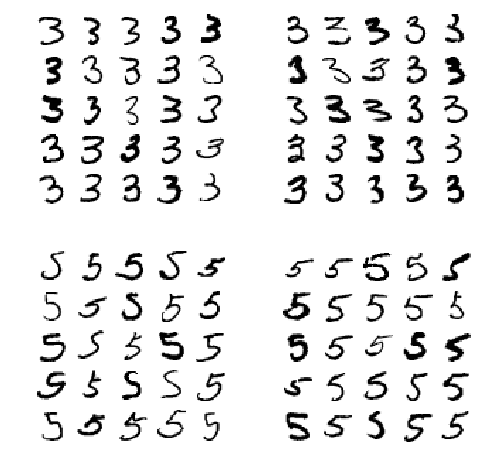

In [32]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
plt.show()

In [ ]:
# Create K-NN Classifier
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(n_neighbors = 5, metric='minkowski', p=2)
knn_clf.fit(X_train, y_train)

y_pred = knn_clf.predict(X_test)
#f1_score(y_train, y_pred, average="macro")

In [2]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train, y_pred)

NameError: name 'y_train' is not defined